In [2]:
import itertools
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from __future__ import division
import math

from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns

## Acquire

In [4]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

df.head(3) ## look ar out dataframe

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""


In [6]:
df.info() ## look at out columns and data types

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13978 non-null  object
 1   timestamp       13978 non-null  object
 2   request_method  13978 non-null  object
 3   status          13978 non-null  int64 
 4   size            13978 non-null  int64 
 5   destination     25 non-null     object
 6   request_agent   13978 non-null  object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


In [7]:
## clean timestamp and format as date time
df.timestamp = df.timestamp.str.replace(r'(\[|\+0000\])', '', regex=True)
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
df = df.set_index('timestamp') ## <-- setting as index

In [8]:
#take out quotation marks, and clean up request_method column
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [9]:
## make megabyte size column
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [10]:
df['size_mb_bin'] = pd.qcut(df['size_mb'], 3, labels=[1, 2, 3])

In [11]:
## looking at new df
df.head(3)

,ip,request_method,status,size,destination,request_agent,size_mb,size_mb_bin
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,0.488753,3
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,0.003396,1
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0,0.486472,2


In [12]:
df.describe().T ## looking at our numeric statistics

,count,mean,std,min,25%,50%,75%,max
status,13978.0,200.356703,10.182001,200.0,200.000000,200.000000,200.000000,4.990000e+02
size,13978.0,450001.905781,161491.467157,0.0,500637.000000,510138.000000,511291.000000,2.056327e+06
size_mb,13978.0,0.429155,0.154010,0.0,0.477445,0.486506,0.487605,1.961066e+00


In [13]:
#make a df with value counts for request address
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_count'})

#make a df with the probability of each ip address
ip_df2 = pd.DataFrame(df.ip.value_counts(dropna=False)/df.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})

#merge the new dfs
ip_df = ip_df.merge(ip_df2)


# see those where rate < 5% 
ip_df[ip_df.ip_proba < .05]

,ip,ip_count,ip_proba
2,72.181.113.170,613,0.043855
3,72.181.105.81,246,0.017599
4,24.26.242.9,21,0.001502
5,68.201.219.223,21,0.001502
6,52.87.230.102,2,0.000143
7,70.121.214.34,2,0.000143
8,35.175.171.137,2,0.000143
9,54.145.52.184,1,0.000072
10,45.23.250.16,1,0.000072
11,54.172.14.223,1,0.000072


 Our Dataframe Length:22

               ip  ip_count  ip_proba
12  97.105.15.120         1  0.000072
13  34.207.64.242         1  0.000072
14   35.174.209.2         1  0.000072
15  34.229.70.250         1  0.000072
16   3.92.201.136         1  0.000072
17   95.31.16.121         1  0.000072
18   3.88.129.158         1  0.000072
19   95.31.18.119         1  0.000072
20  52.90.165.200         1  0.000072
21   52.91.30.150         1  0.000072


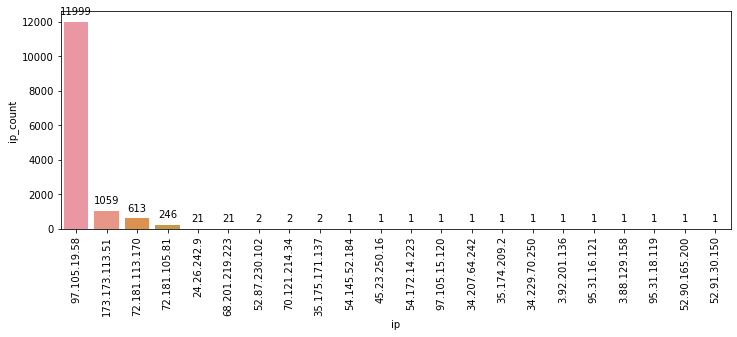

In [15]:

print(f' Our Dataframe Length:{len(ip_df)}\n')

print(ip_df.tail(10))

#barplot of ip addresses and their counts
plt.figure(figsize=(12, 4))
splot = sns.barplot(data=ip_df, x = 'ip', y = 'ip_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

In [16]:
#create train from the following dates, with these columns
train = df.loc['2019-04-16 19:34:42':'2019-04-17 12:55:14']
train = train[['ip','request_method','status','size','destination','request_agent','size_mb_bin']]

In [18]:
train.head(3) ## looking at train

,ip,request_method,status,size,destination,request_agent,size_mb_bin
timestamp,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,3
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,1
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0,2


In [19]:
#taking value counts of the ip addresses with these columns
ip_df = pd.DataFrame(train.ip.value_counts(dropna=False)/train.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})

In [20]:
ip_df

,ip,ip_proba
0,97.105.19.58,0.858595
1,173.173.113.51,0.075784
2,72.181.113.170,0.043867
3,72.181.105.81,0.017604
4,68.201.219.223,0.001503
5,24.26.242.9,0.001503
6,52.87.230.102,0.000143
7,70.121.214.34,0.000143
8,35.175.171.137,0.000143
9,45.23.250.16,0.000072


In [21]:
df['size_mb_bin']= df['size_mb_bin'].astype(int)

In [22]:
#missing values to 0
df = df.reset_index().merge(ip_df, on=['ip'], how='left').fillna(value=0).set_index('timestamp')

In [23]:
ip_probs = train.groupby('ip').size().div(len(df))

size_given_ip = pd.DataFrame(train.groupby(['ip', 'size_mb_bin']).\
                               size().div(len(train)).\
                               div(ip_probs, 
                                   axis=0, 
                                   level='ip').\
                               reset_index().\
                               rename(index=str, 
                                      columns={0: 'proba_size_category_given_ip'})
                              )

In [24]:
ip_size_count = pd.DataFrame(train.groupby(['ip', 'size_mb_bin'])['request_method'].\
                                count().reset_index().\
                                rename(index=str, 
                                       columns={'request_method': 'ip_size_count'}))


ip_size = size_given_ip.merge(ip_size_count)

In [25]:
df = df.reset_index().merge(ip_size, on=['ip', 'size_mb_bin'], how='left').fillna(value=0).set_index('timestamp')

In [26]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb,size_mb_bin,ip_proba,proba_size_category_given_ip,ip_size_count
timestamp,,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.488753,3,0.858595,0.335985,4030.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,1,0.858595,0.327648,3930.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.486472,2,0.858595,0.336652,4038.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.486377,2,0.858595,0.336652,4038.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.488246,3,0.858595,0.335985,4030.0
